In [1]:
import torch
import torch.nn as nn
from openmmtorch import TorchForce
import os

import yaml
from pathlib import Path


import numpy as np
from openmm.app import *
from openmm import *
from openmm.unit import *


from sys import stdout

from maputils import EquiValReporter

import training_modules as tm

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss
import matplotlib.pyplot as plt
from torch.utils.data import Dataset , DataLoader
from training_utils import CGDataset , TrainSystem


In [2]:
import torch

torch.cuda.is_available()

True

In [3]:
import os
import yaml
import numpy as np
from pathlib import Path
from cgmap.utils import DataDict
from cgmap.mapping import Mapper

from typing import Dict

from aggforce import linearmap as lm
from aggforce import agg as ag
from aggforce import constfinder as cf

/home/enere@usi.ch/miniconda3/envs/CGffap/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:


# Assign directory
input_directory = 'StartingStructures'

output_directory = '../datasets/leapfrog'

trj_list = []

for name in os.listdir(output_directory):
    if name.endswith(".trr"):
        trj_list.append(output_directory + '/' + name)

print(trj_list)

['../datasets/leapfrog/chignolin_frames0.trr', '../datasets/leapfrog/chignolin_frames1.trr', '../datasets/leapfrog/chignolin_frames2.trr', '../datasets/leapfrog/chignolin_frames3.trr', '../datasets/leapfrog/chignolin_frames4.trr', '../datasets/leapfrog/chignolin_frames5.trr', '../datasets/leapfrog/chignolin_frames6.trr', '../datasets/leapfrog/chignolin_frames7.trr', '../datasets/leapfrog/chignolin_frames8.trr', '../datasets/leapfrog/chignolin_frames9.trr', '../datasets/leapfrog/chignolin_frames10.trr', '../datasets/leapfrog/chignolin_frames11.trr', '../datasets/leapfrog/chignolin_frames12.trr', '../datasets/leapfrog/chignolin_frames13.trr', '../datasets/leapfrog/chignolin_frames14.trr', '../datasets/leapfrog/chignolin_frames15.trr', '../datasets/leapfrog/chignolin_frames16.trr', '../datasets/leapfrog/chignolin_frames17.trr', '../datasets/leapfrog/chignolin_frames18.trr', '../datasets/leapfrog/chignolin_frames19.trr', '../datasets/leapfrog/chignolin_frames20.trr', '../datasets/leapfrog/

In [8]:
config = {
    'mapping': 'martini3',
    'input': 'StartingStructures/chignolin_frames0.pdb',
    'inputtraj': trj_list,
    'selection': 'protein',
    'output': 'pro.gro',
    'outputtraj': 'xtc',
    #'trajslice': slice(100,10000)
}

# Map atoms to beads (only protein for now)
mapping = Mapper(config)
mapping.map()
dataset = mapping.dataset

# force_set = forces[:,162]


Missing TYR_H1 in mapping file
Missing TYR_H2 in mapping file
Missing TYR_H3 in mapping file
Missing TYR_OXT in mapping file


In [9]:
current_dir = os.getcwd()

output_file = os.path.join(current_dir, "dataset.LepFrogMix.npz")
np.savez(output_file, **mapping.dataset)
print(f"{output_file} successfully saved!")

/home/enere@usi.ch/CGffap/dataset.LepFrogMix.npz successfully saved!


In [4]:
dataset = dict(np.load('dataset.VoidNoPBC.npz', allow_pickle=True))

In [5]:
dataset['atom_forces'].max(axis=1)

array([[ 258.09448242,  397.75302124,  376.83535767],
       [ 257.30148315,  396.24468994,  378.81912231],
       [ 250.25767517,  389.88162231,  368.30709839],
       ...,
       [1034.04541016, 1166.85498047,  708.02416992],
       [ 826.38262939,  801.58703613,  875.0536499 ],
       [ 808.32910156,  924.3192749 ,  730.23144531]])

In [6]:
equvalrep = EquiValReporter(dataset=dataset)

equvalrep.bondMapper(config_file_path="config files/bond_config.yaml")
equvalrep.angleMapper(conf_angles_path="test_conf/config.angles.yaml")
equvalrep.improperDihedralMapper()
equvalrep.beadChargeMapper()

Side Chain Bond Matrix Shape (54, 2)
All bonds Mat Shape (72, 2)
Bonds to be removed [] Bonds to be replaced with correct value []
Number of issued found: 0
Number of issues remain: 0


True

In [7]:
equvalrep.reportEquiVals(reportPath='test_conf/')

test_conf/config.dihedrals.yaml successfully saved!
test_conf/config.angles.yaml successfully saved!
test_conf/config.bonds.yaml successfully saved!
test_conf/config.beadcharges.yaml successfully saved!


In [8]:
dataset = equvalrep.getDataset()

# print(dataset['bead_forces'][:].sum(axis=-1).sum(axis=-1))

# dataset['bead_forces'] = (dataset['bead_forces'][:,:,:] - (dataset['bead_forces'][:,:,:].sum(axis=1)/len(dataset['bead_types']))[:,None,:])

# print(dataset['bead_forces'][:].sum(axis=-1).sum(axis=-1))


In [9]:
conf_bonds: dict = equvalrep.getBonds()
conf_angles: dict = equvalrep.getAngles()
conf_dihedrals: dict = equvalrep.getImproperDihs()
conf_bead_charges: dict = equvalrep.getBeadCharges()

In [10]:
dataset['bead_pos'] = dataset['bead_pos'][:4000]
dataset['bead_forces'] = dataset['bead_forces'][:4000]

In [11]:

system = TrainSystem(dataset, conf_bonds, conf_angles, conf_dihedrals, conf_bead_charges, device_index=0)

model = system.initialteTraining(dataset = dataset, train_steps=10000, batch_size=4000, patience=60, model_name='best_model_chig_LeapFrogNMNoPBCFoldedLJABS.pt')

#1111954.7954712936
#84162454.73250054
#74196367.16324478
#20649546.659804508
#32376695.334399514
#32260497.67279769
#6814748.68196779

/home/enere@usi.ch/CGffap/training_modules.py:90: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1711323198313/work/torch/csrc/utils/tensor_new.cpp:261.)
  self.bead_charges_vals = torch.nn.Parameter(torch.reshape(torch.Tensor([i for i in conf_bead_charges.values()]).float().to(self.device), (-1,)))


Epoch 1: Train Loss = 83.95320197337011, Validation Loss = 85.02869755984236, Zero Loss = 16.918859667650707
Epoch 2: Train Loss = 77.89566602540744, Validation Loss = 78.95414269618405, Zero Loss = 16.918859667650707
Epoch 3: Train Loss = 73.88059015850645, Validation Loss = 74.86755567962953, Zero Loss = 16.918859667650707
Epoch 4: Train Loss = 70.82333846024191, Validation Loss = 72.01574625137097, Zero Loss = 16.918859667650707
Epoch 5: Train Loss = 68.30746921982525, Validation Loss = 69.35392861950632, Zero Loss = 16.918859667650707
Epoch 6: Train Loss = 66.67366809147168, Validation Loss = 67.78516852594022, Zero Loss = 16.918859667650707
Epoch 7: Train Loss = 65.87604672746991, Validation Loss = 66.97414215904429, Zero Loss = 16.918859667650707
Epoch 8: Train Loss = 65.67886807474562, Validation Loss = 66.60637845601677, Zero Loss = 16.918859667650707
Epoch 9: Train Loss = 64.305819743757, Validation Loss = 65.20988554391113, Zero Loss = 16.918859667650707
Epoch 10: Train Loss 

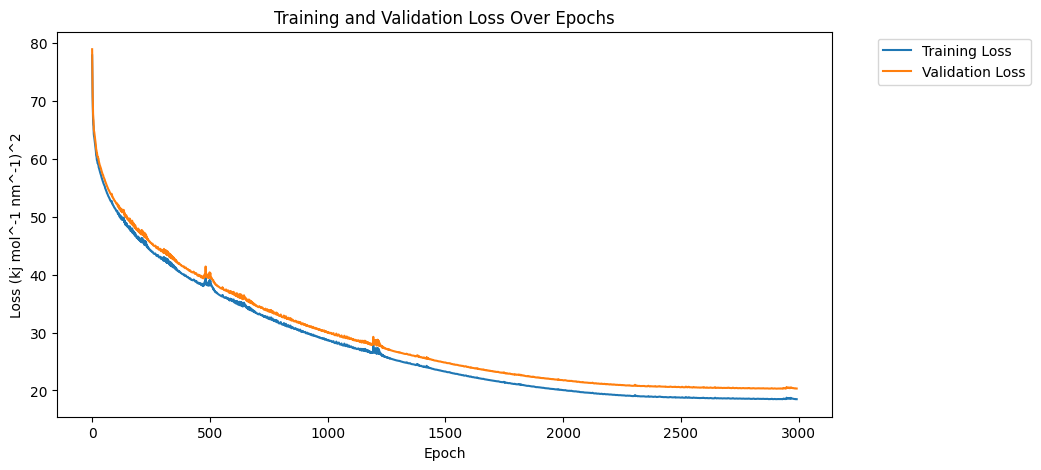

In [12]:
system.plotLosses(truncate=1)

In [13]:
system.batched_forces_plot[0].shape

(3600, 32, 3)

<Figure size 1000x500 with 0 Axes>

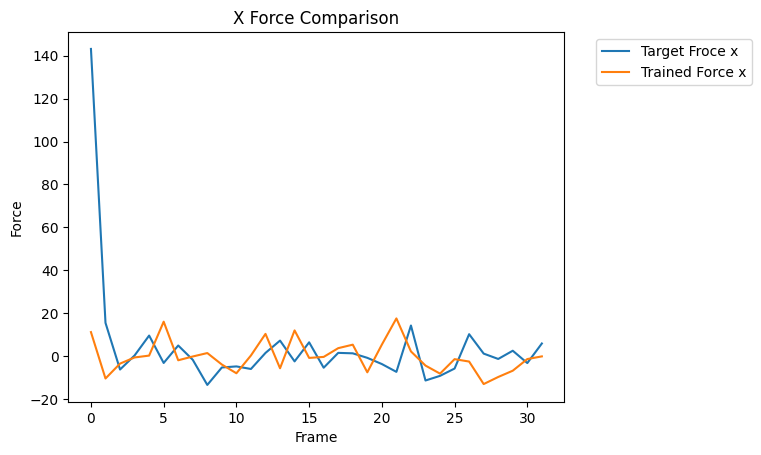

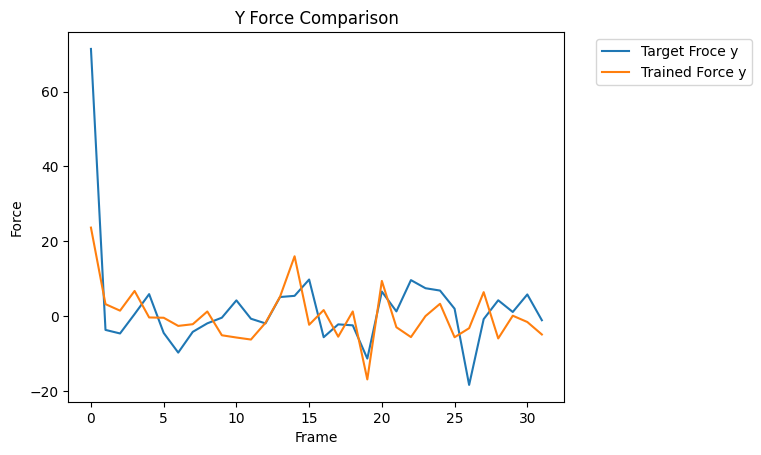

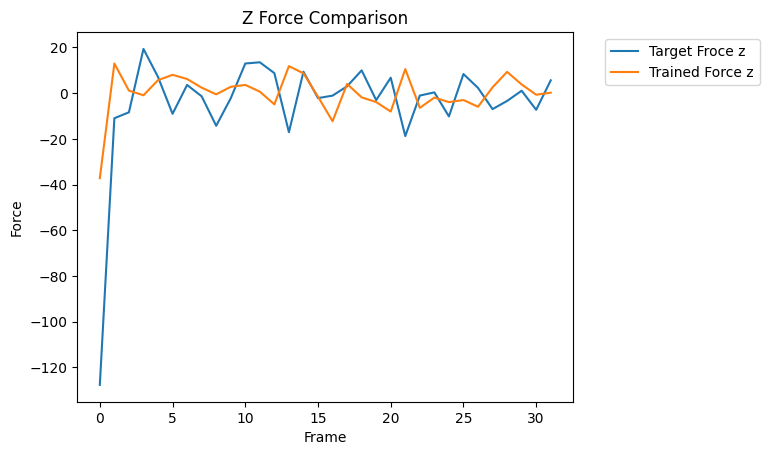

In [14]:
system.plotForceMathingByFrame(frame=100)

<Figure size 1000x500 with 0 Axes>

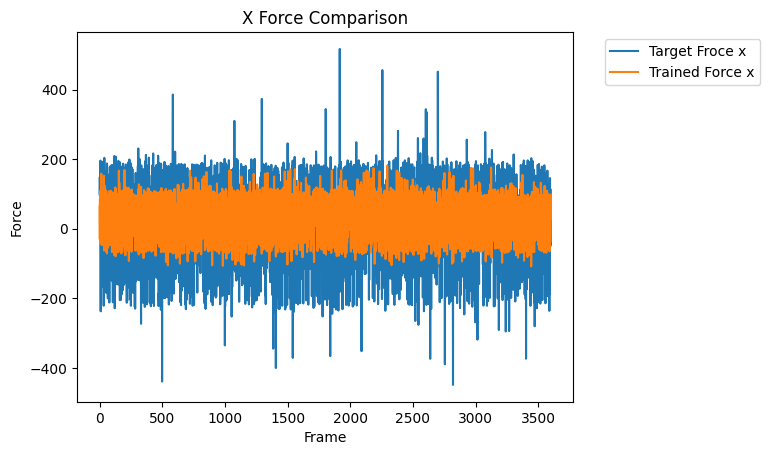

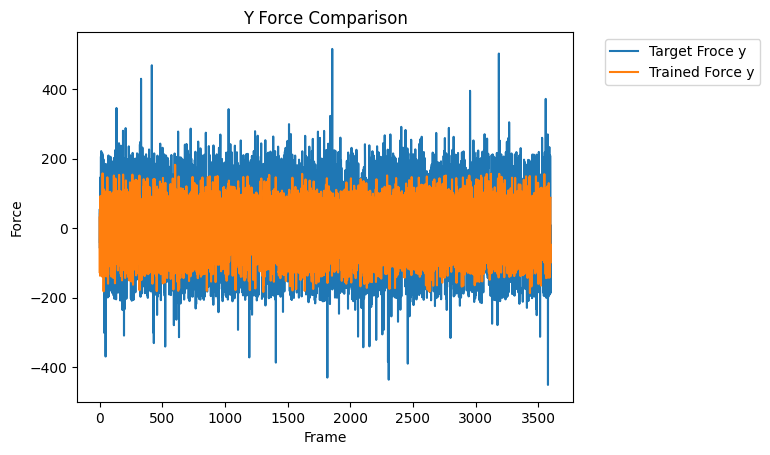

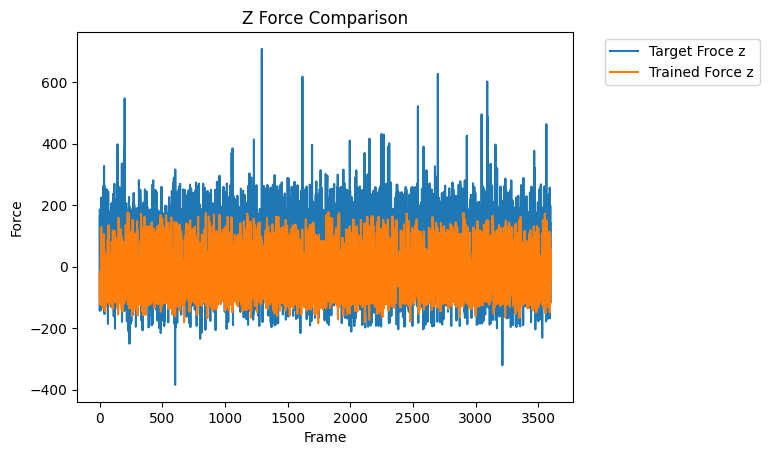

In [15]:
system.plotInitialForceGuess()

<Figure size 1000x500 with 0 Axes>

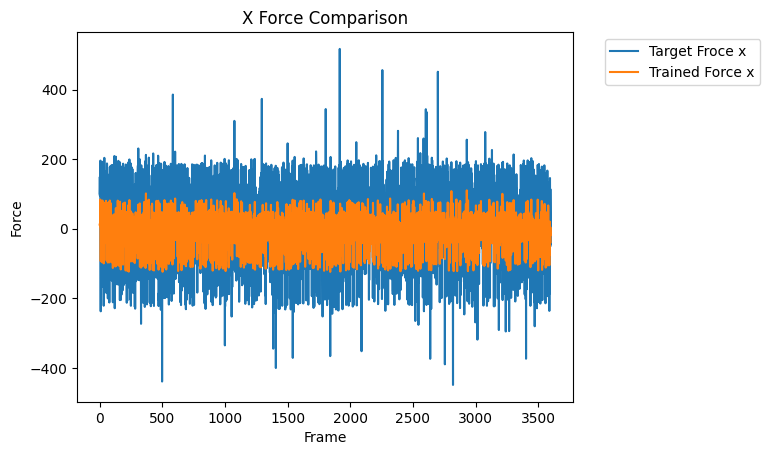

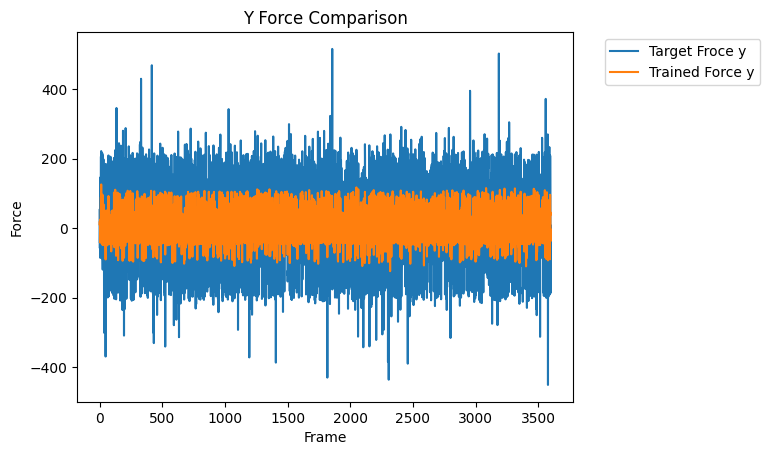

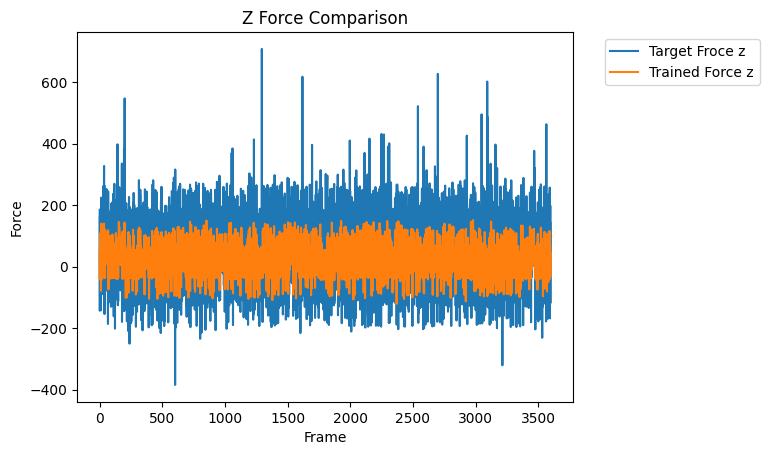

In [16]:
system.plotForceMathing()

<Figure size 1000x500 with 0 Axes>

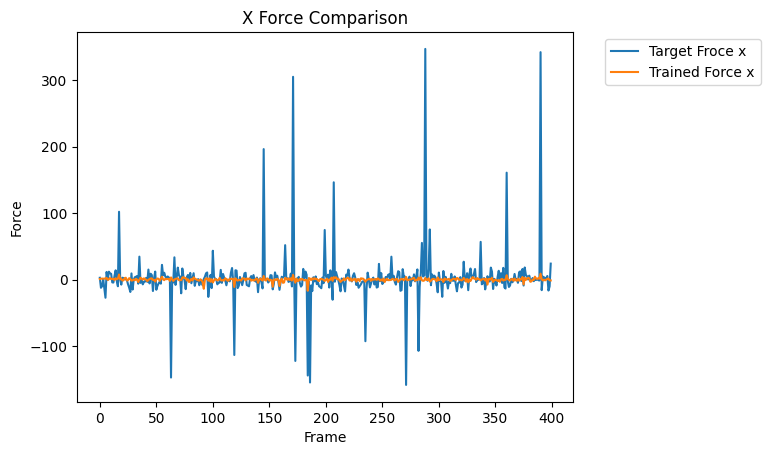

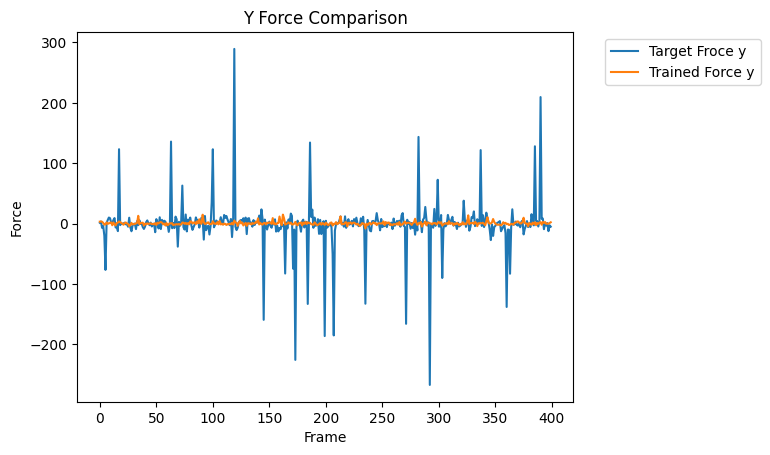

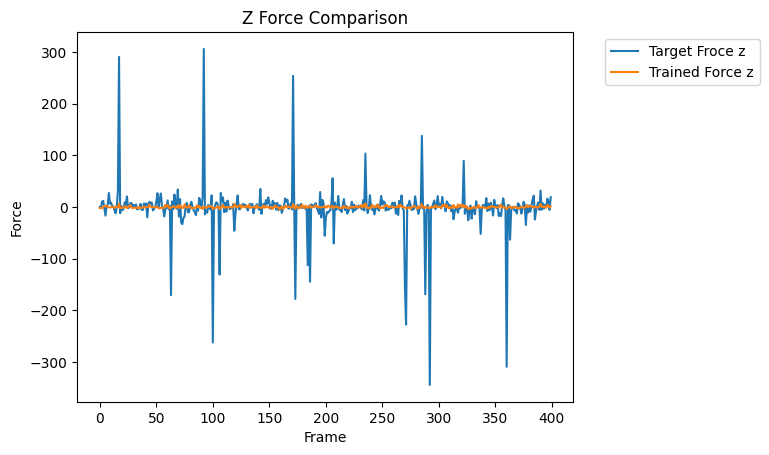

In [17]:
system.plotValForceMathing(bead_index=30)

<Figure size 1000x500 with 0 Axes>

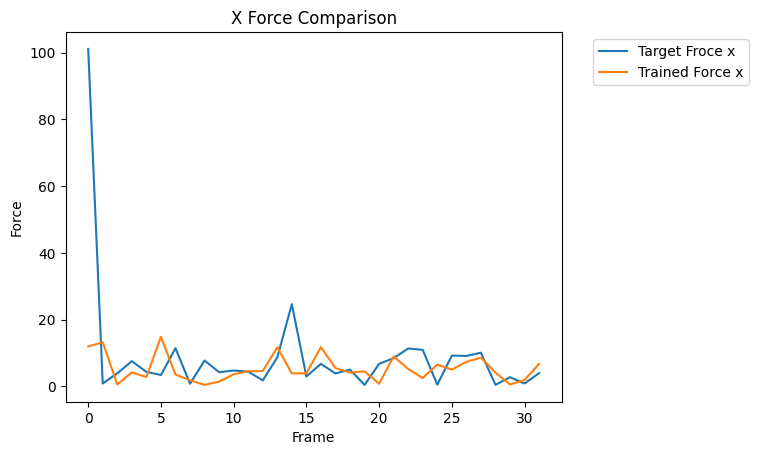

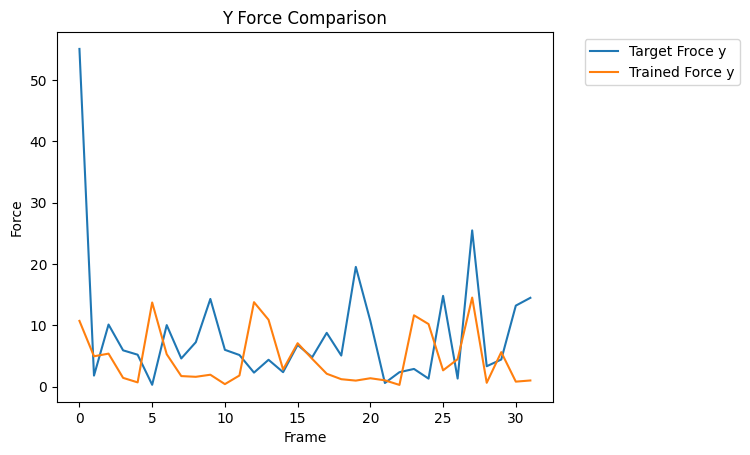

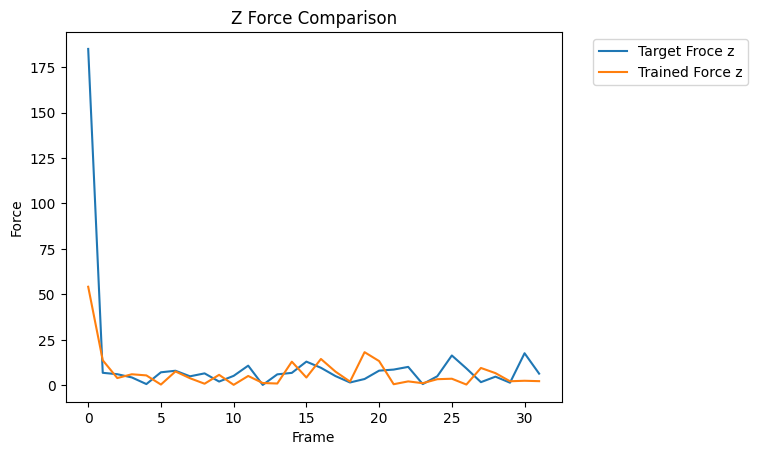

In [18]:
system.plotABSForceMathing(frame=0)

In [19]:
system.state_dict()

OrderedDict([('potential.dispertion_const',
              tensor([ 8.1774e+00,  1.8971e+00,  9.8724e+00,  1.1210e+01,  1.8445e+00,
                       8.8242e+00,  1.9436e+00,  3.8982e+00,  2.3035e+00,  1.9246e+00,
                       4.3259e+00,  1.8710e+00,  8.1960e+00,  2.4013e+00,  2.0929e+00,
                       1.5051e+00,  2.6112e+00,  3.9583e+00,  1.8378e+00,  1.7212e+00,
                       7.0199e+00, -1.7231e-04,  3.0174e+00,  1.8987e+00,  1.7880e+00,
                       1.8338e+00,  2.1488e+00,  1.7951e+00,  2.1027e+00, -1.7034e-01,
                       1.9366e+00,  1.7877e+00,  3.2514e+00,  1.9311e+00,  2.9277e+01,
                       8.6881e+00,  2.1237e+00,  1.8720e+00,  5.5114e+00,  2.8830e+00,
                       1.8870e+00, -1.4872e+00,  3.5417e+00,  1.8593e+00,  6.5684e+00,
                       1.7580e+00,  2.0548e+01,  5.0905e+00,  5.0622e+00,  1.1543e+01,
                       9.4965e-01,  1.7097e+01,  1.6301e+00,  7.7797e+00,  1.9158e+00,

In [16]:

pdb_file = os.path.join("/home/enere@usi.ch/FMartIP/ChigCG.pdb" ) #'/home/enere@usi.ch/FMartIP/original_CG_A2A.pdb' "ChignCG_unfolded.pdb" "original_CG_A2A.pdb" "chig_CG/original_CG_a2a_Water.pdb" 
# "/home/enere@usi.ch/FMartIP/chig_CG/original_CG_a2a_4.pdb"
pdb = PDBFile(pdb_file) # OpenMM loader

In [17]:
index = 300    
for atom, bead in zip(pdb.topology.atoms(), np.unique(dataset['bead_names'])):
    # print(chr(index + 150))
    i = dataset['bead_types'][np.where(dataset['bead_names'] == bead)]
    print(i[0])
    mass = 0 #dataset['bead_mass_dict'][bead]
    print(mass*amu)
    print(bead)
    atom.element = Element(number = i[0], name = bead, symbol = chr(index), mass = mass*amu)
    index +=3
    print(Element.getByAtomicNumber(i[0]))

1
0 Da
BB
<Element BB>
37
0 Da
SC1
<Element SC1>
38
0 Da
SC2
<Element SC2>
39
0 Da
SC3
<Element SC3>
40
0 Da
SC4
<Element SC4>
36
0 Da
SC5
<Element SC5>


In [18]:
system = System()

for atom in pdb.topology.atoms():
    # print(atom)
    # print(dataset['bead_mass'][atom.index])
    system.addParticle(atom.element.mass)

boxVectors = pdb.topology.getPeriodicBoxVectors()
if boxVectors is not None:
    system.setDefaultPeriodicBoxVectors(boxVectors[0], boxVectors[1], boxVectors[2])
print(boxVectors)


(Vec3(x=5.5366, y=0.0, z=0.0), Vec3(x=0.0, y=4.6735, z=0.0), Vec3(x=0.0, y=0.0, z=4.8997)) nm


In [19]:
force = TorchForce(model)

integrator = NoseHooverIntegrator(300*kelvin, 1/picosecond, 0.010*picoseconds)


while system.getNumForces() > 0:
    system.removeForce(0)
    
# The system should not contain any additional force and constrains
assert system.getNumConstraints() == 0
assert system.getNumForces() == 0

# Add the NNP to the system
system.addForce(force)

# This line combines the molecular topology, system, and integrator to begin a new simulation. It creates a Simulation object and assigns it to a variable called simulation. 
# A Simulation object manages all the processes involved in running a simulation, such as advancing time and writing output.
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

# Performs a local energy minimization. It is usually a good idea to do this at the start of a simulation, since the coordinates in the PDB file might produce very large forces.
simulation.minimizeEnergy()
print("starting Sim")

simulation.reporters.append(PDBReporter('output.pdb', 100))
simulation.reporters.append(StateDataReporter('output.dat', 100, step=True, potentialEnergy=True, kineticEnergy=True, temperature=True, time=True, totalEnergy=True))

#This line adds another reporter to print out some basic information every 1000 time steps
simulation.step(50000)
state = simulation.context.getState(getPositions=True, getEnergy=True, getForces=True)
f = np.array([[a.x,a.y,a.z]for a in state.getForces()])
p = np.array([[a.x,a.y,a.z]for a in state.getPositions()])
# print(state.getForces(), state.getPositions())

NameError: name 'TorchForce' is not defined